# Rotation Calculations

A notebook to take two sets of centroids and calculate the centre and angle of rotation.

This can be run both on images from disk (performing centroids locally) or with centroids from the database. A clean set of centroids is required. 



# To Run at Subaru

Change the FrameIDs (frame1, frame2) to the desired values. 



# Import stuff


In [92]:
%matplotlib notebook

import vis_plotting as visplot        #plotting routines 
import vis_calculations as viscalc    #calculation routines
import vis_coordinates as viscoords   #routines related to coordinate transforms
import numpy as np
from importlib import reload  #for development/debugging purposes
import matplotlib.pylab as plt
import cv2

#other parameters

#inter=1 displays to screen and file, inter=0 for script work. 
inter=1

#search radius for matching points

tol=5
#region on interest (needed if there is crap at the edge of the image contaminating the centroids)
#form=[x1,y1,x2,y2]

roi=[0,0,8960,5778]



# Local Files

Reads in two files and calculates the centroids locally. 


In [93]:

#centroid parameters

#basic parameters - threshold probably needs to be tuned it should be 
#above the background but below the lowest peak value. 
fwhm=3        
boxsize=9
thresh=2500

#shape parameters for centroiding. If the points are not circular,
#rl and rh may need to be changed; -1, 1 are the values for a circular
#psf. sl and sh should probably not need to be changed

rl=-2.5
rh=1.3
sl=0.05
sh=0.5


<IPython.core.display.Javascript object>


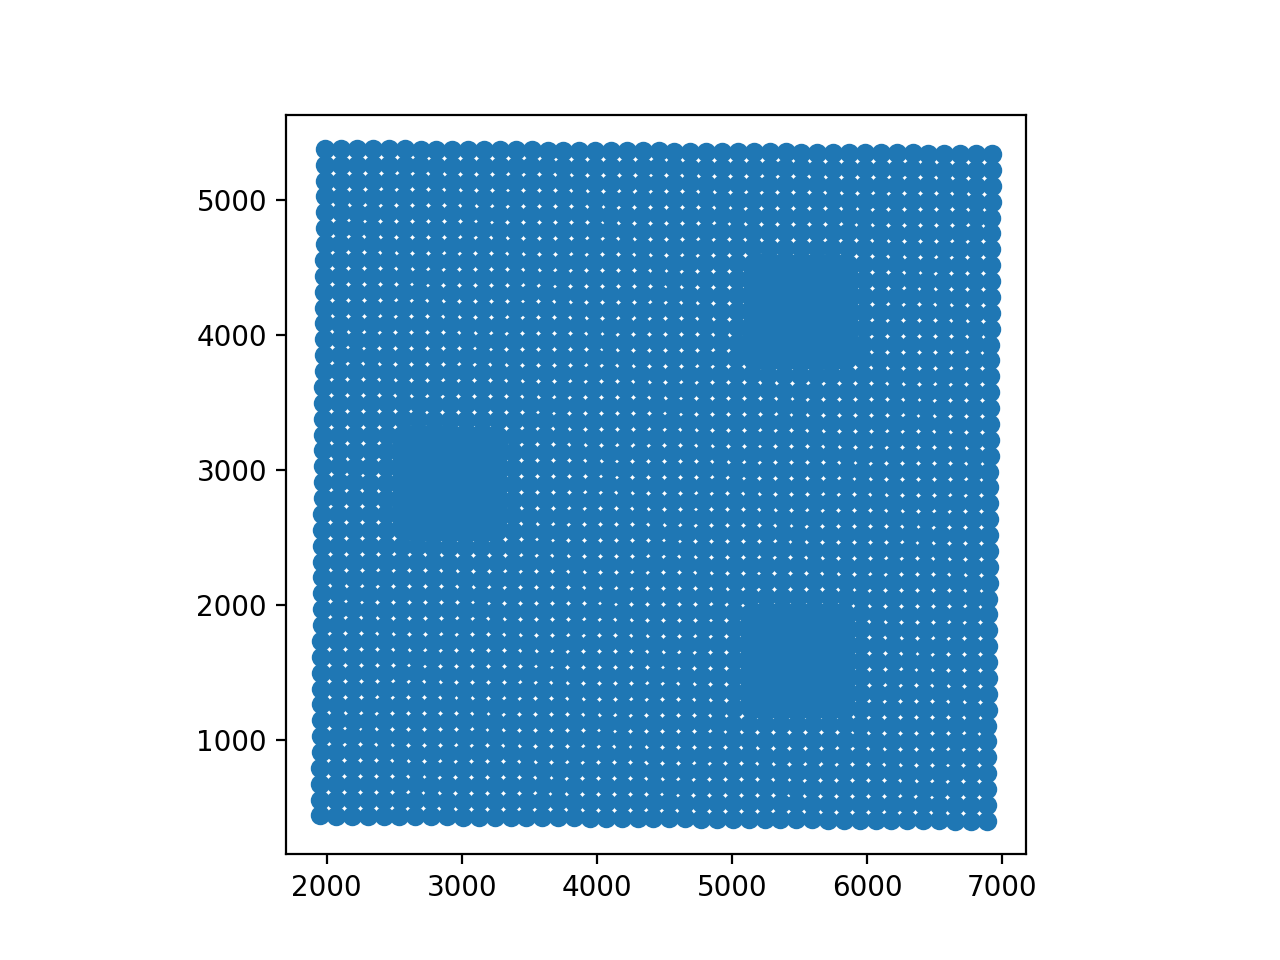

<IPython.core.display.Javascript object>


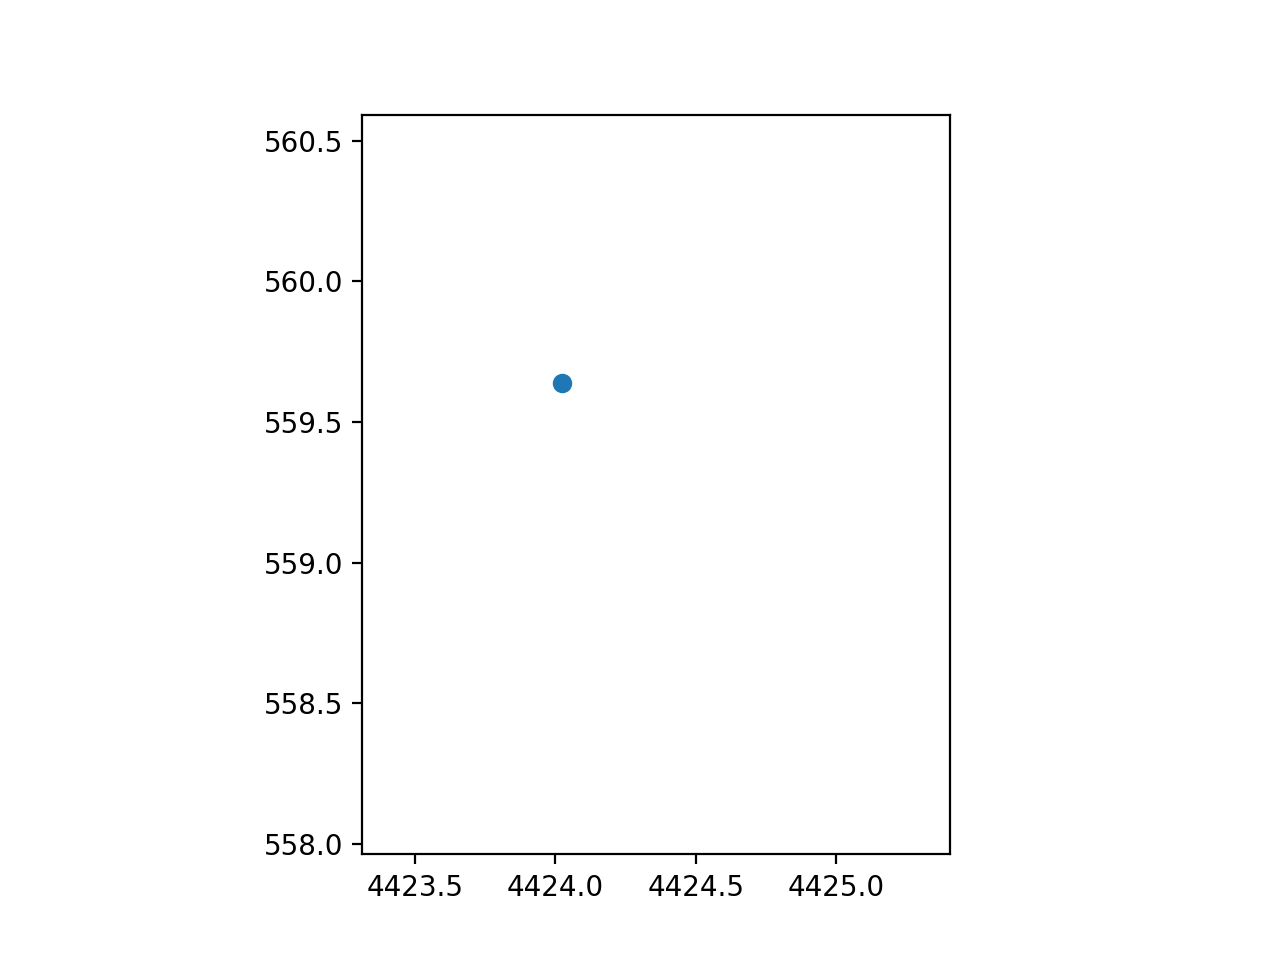

In [74]:
#simulated rotation for testing - ignore if real data

xt=3000.
yt=4500.
theta1=0.0
theta2=0.6

x1,y1=viscoords.transformGeneral(x1,y1,0,0,theta1,1,xt,yt)
x2,y2=viscoords.transformGeneral(x2,y2,0,0,theta2,1,xt,yt)

visplot.checkCentroids(x1,y1,0,prefix,inter)
visplot.checkCentroids(x2,y2,0,prefix,inter)



In [94]:
#get the centroids from file

#read the files

file1 = "MCST_010_001.fits"
file2 = "MCST_010_002.fits"

image1=visplot.getImage(file1)
image2=visplot.getImage(file2)

fwhm=3        
boxsize=9
thresh=2200
rl=-2.5
rh=1.5
sl=0.05
sh=0.5

inter=1
prefix="test"

x1,y1,fx1,fy1,back1,peak1=viscalc.getCentroids(image1,fwhm,boxsize,thresh,rl,rh,sl,sh)
x2,y2,fx2,fy2,back2,peak2=viscalc.getCentroids(image2,fwhm,boxsize,thresh,rl,rh,sl,sh)


# Database Version





In [ ]:

#connect to the database


try:
    file = open("/Users/chyan/Documents/workspace/ics_mcsActor/etc/dbpasswd.cfg", "r")
    passstring = file.read()
    print('text="Password reading OK. value = %s."'%(passstring))
except:
    print('text="could not get db password"')

try:
    conn = psycopg2.connect("dbname='fps' user='pfs' host='133.40.164.208' password=pfspass")
    #conn = psycopg2.connect("dbname='fps' user='pfs' host='133.40.164.208' password="+passstring)
    print('text="Connected to FPS database."')
except:
    print('text="I am unable to connect to the database."')
    

In [ ]:

Read the centroids from the database, given a pair of frameIDs. 

frameId1=240
frameId2=241
moveId1=1
moveId2=1

dayDir="/data/mcs/2018-10-15/"



cmd_string1 = f"""select * from mcsEngTable where frameId={frameId1} and moveId={moveId1}"""
cmd_string2 = f"""select * from mcsEngTable where frameId={frameId2} and moveId={moveId2}"""

#code from Chi-Hung
data=np.array([])
n = 0
with conn.cursor() as curs:
        curs.execute(cmd_string1)
        rows=curs.fetchall()
        for idx, val in enumerate(rows):
            if idx == 0: data = val 
            if idx != 0: data = np.vstack([data,val])
conn.commit()

centroids1=data[:,4:11]
#filename=???  ##need to sett his, and check ID numbers

data=np.array([])
n = 0
with conn.cursor() as curs:
        curs.execute(cmd_string2)
        rows=curs.fetchall()
        for idx, val in enumerate(rows):
            if idx == 0: data = val 
            if idx != 0: data = np.vstack([data,val])
conn.commit()

centroids2=data[:,4:11]

#get the centroids from the structure
x1=centroids1[:,1]
y1=centroids1[:,2]
x2=centroids2[:,1]
y2=centroids2[:,2]

filename1=daydir+"PFSC"+str(frameId1).zfill(6)+"00.fits"
filename2=daydir+"PFSC"+str(frameId2).zfill(6)+"00.fits"

prefix="rot_"+str(frameId1)+"_"+str(frameId2)


# Analysis

This section is the same regardless of the source of the centroids

<IPython.core.display.Javascript object>


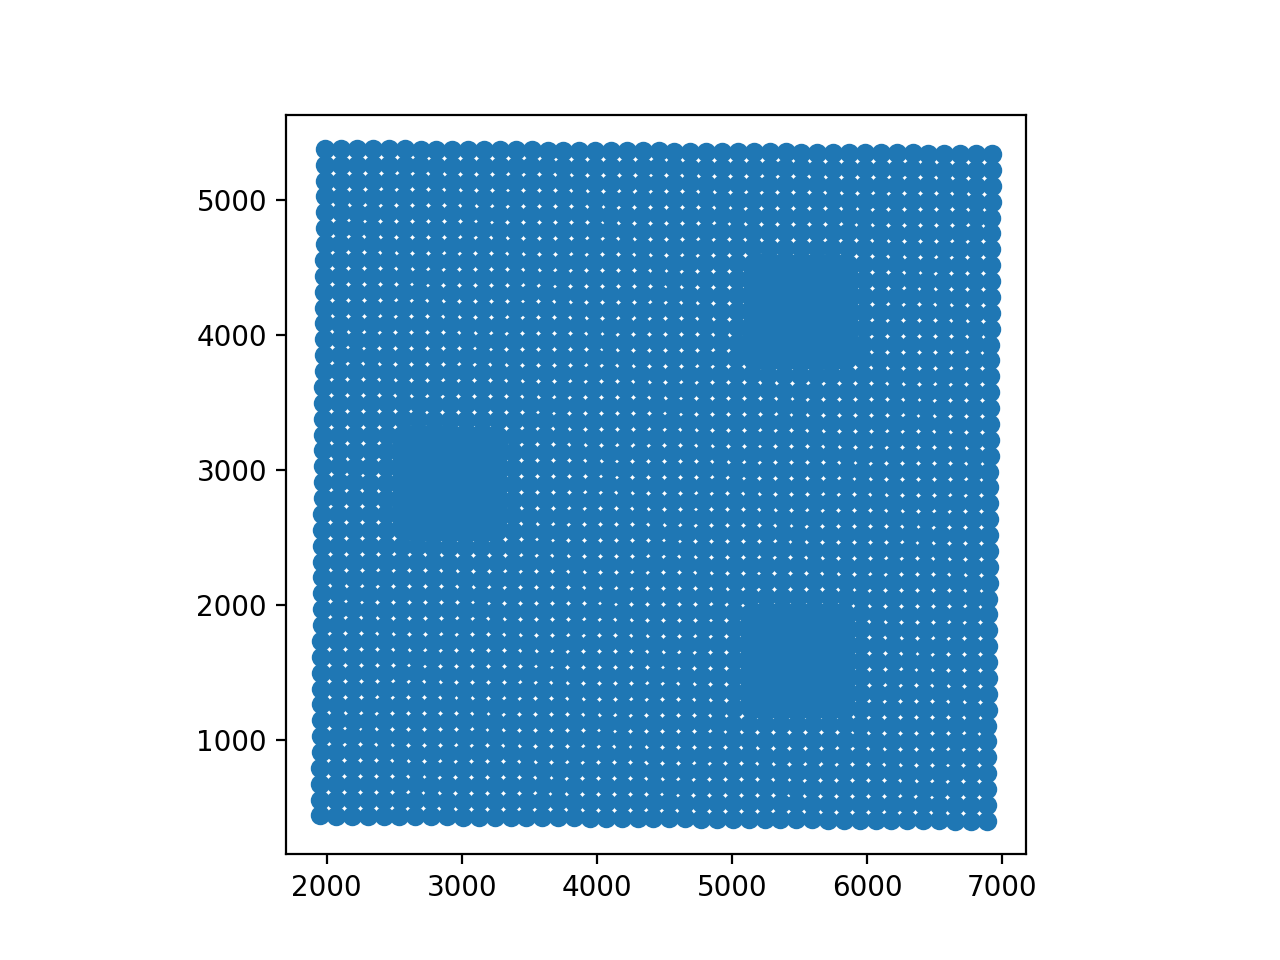

<IPython.core.display.Javascript object>


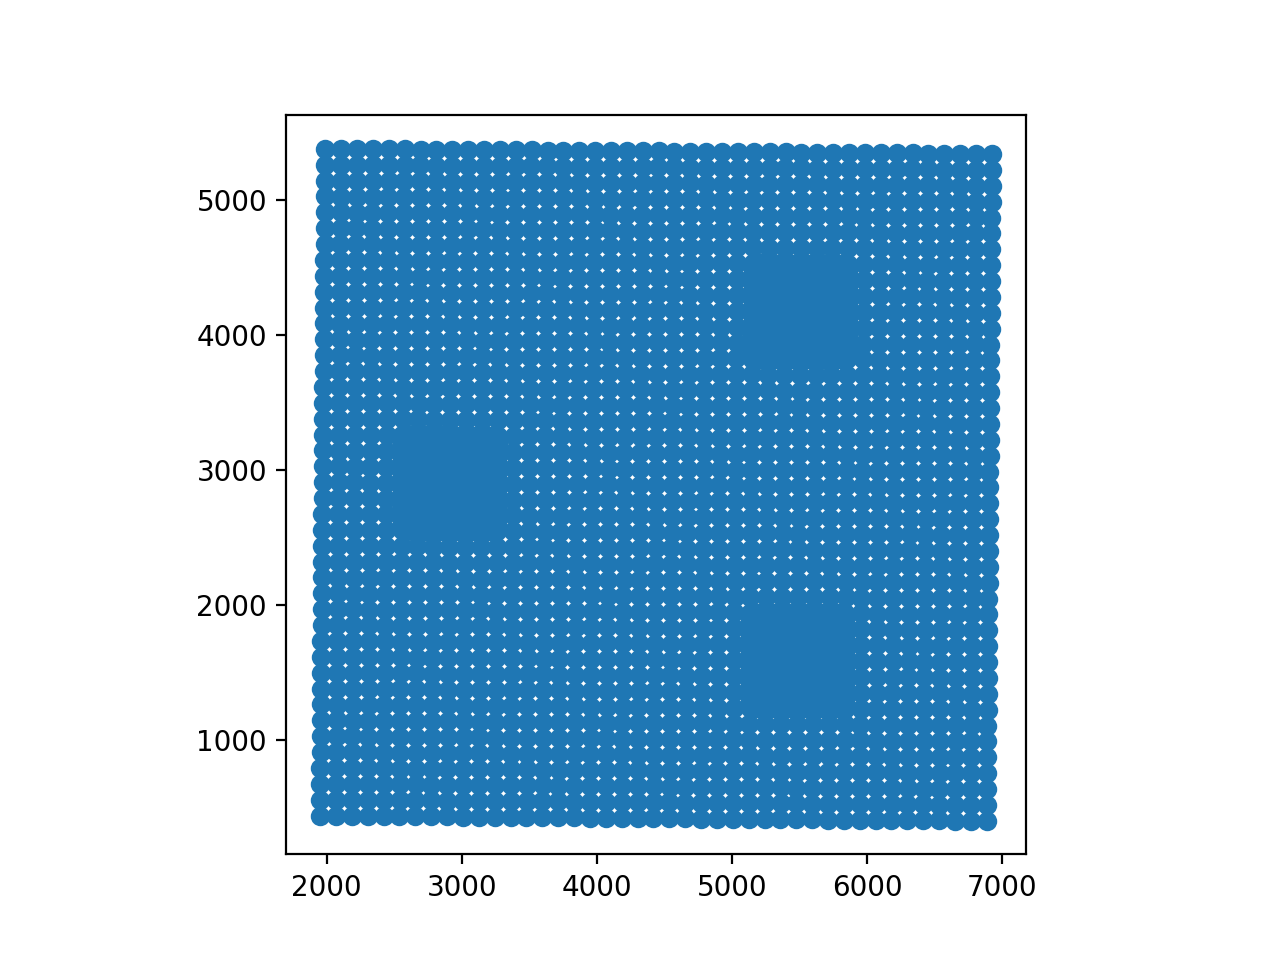

In [96]:

#check the centroids

visplot.checkCentroids(x1,y1,0,prefix,inter)
visplot.checkCentroids(x2,y2,0,prefix,inter)



In [99]:

reload(viscoords)

#get approximate transform FROM MASK for each set of images

xma,yma,xd1a,yd1a,anglea,scalea=viscoords.getApproximateTransform(x1,y1,1)
xmb,ymb,xd1b,yd1b,angleb,scaleb=viscoords.getApproximateTransform(x2,y2,1)

#print(xd1a,yd1a,anglea,scalea)
#print(xd1b,ydab,angleb,scaleb)

#turn those elements into a matrix
matrix1=viscoords.elementsToMatrix(scalea,scalea,xd1a,yd1a,anglea,3)
matrix2=viscoords.elementsToMatrix(1/scaleb,1/scaleb,-xd1b,-yd1b,-angleb,3)

#print(matrix1)
#print(matrix2)

#combine the transforms (note 3x3 format)
M=np.matrix(matrix2)*np.matrix(matrix1)

#transform one set to the other set for registration
x2c,y2c=viscoords.transformPointsMatrix(x2,y2,M[0:2,:])

x2c=x2c-x2c.mean()
y2c=y2c-y2c.mean()
x1c=x1_rot-x1_rot.mean()
y1c=y1_rot-y1_rot.mean()


<IPython.core.display.Javascript object>


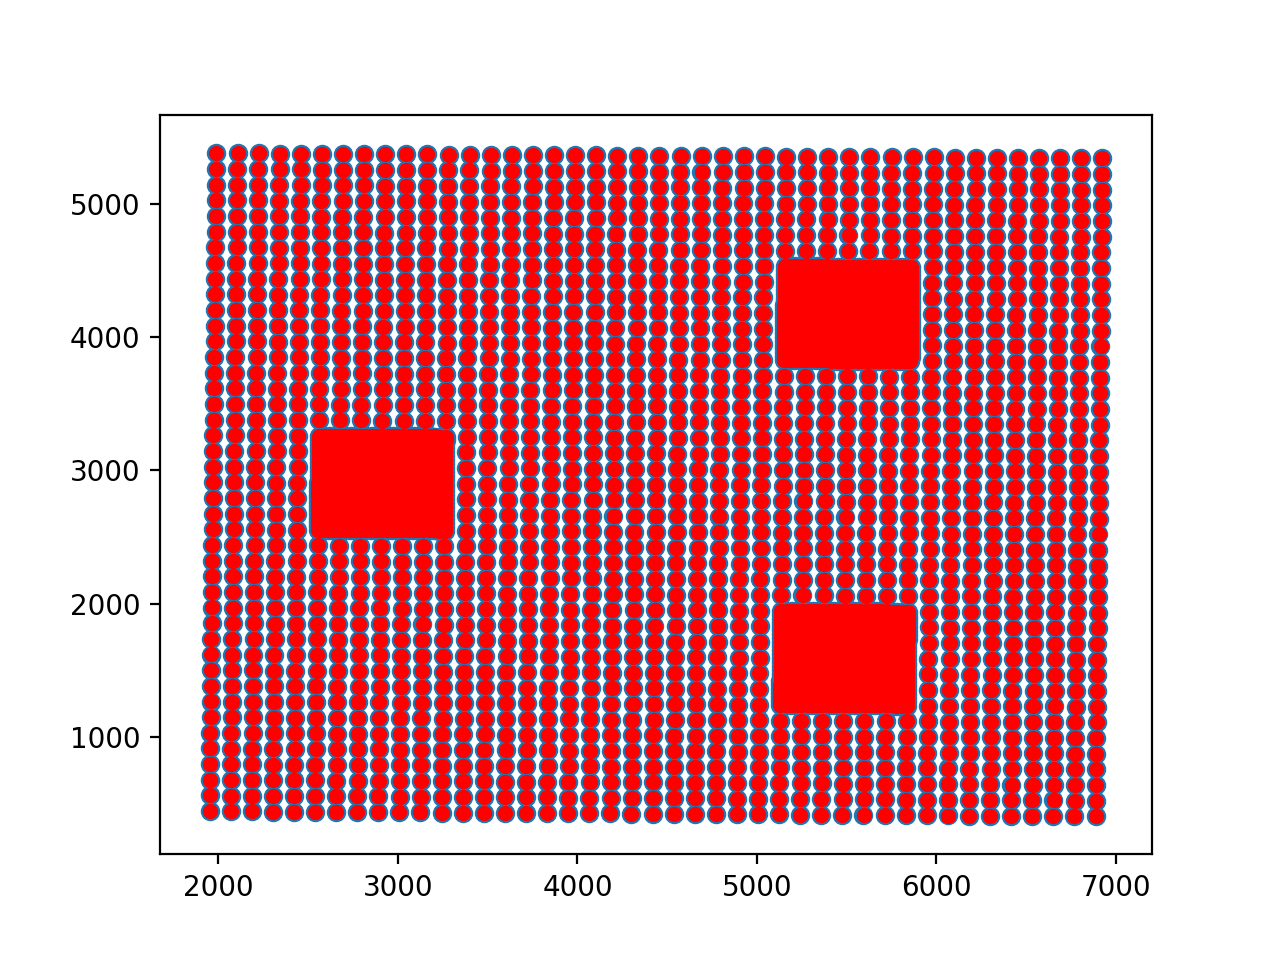

In [100]:
reload(viscoords)

#register the points with each other

x1r,y1r,x2r,y2r=viscoords.matchPointsRot(x1c,y1c,x2c,y2c,x1,y1,x2,y2,tol)

#visplot.checkMatched(x2c,y2c,x1c,y1c,prefix,inter)
visplot.checkMatched(x1r,y1r,x2r,y2r,prefix,inter)


In [101]:

#calculate the transform between the two sets of points

transformation,xd,yd,sx,sy,rotation=viscoords.getTransform(x1r,y1r,x2r,y2r,1)

#and extract the centre of rotation
xc,yc=viscoords.getCentre(transformation)

print(xc,yc,rotation)

[ 0.00934369 -0.00896436]
0.00934369347016 -0.00896435799825 3.91107800453e-06


# Backup Code

Backup for calculating approximate transformations based on three matching points

In [103]:

#two sets of points from each set of centroids. Format of input is
#format is [[x1,x2,x3],[y1,y2,y3],[1,1,1]]

m1=[[5765.1,8520.0,4424.0],[7410.0,3314.4,559.6],[1,1,1]]
m2=[[6925.2,6886.5,1950.5],[5340.8,404.5,443.9],[1,1,1]]

M=np.matrix(m1)*np.linalg.inv(np.matrix(m2))
xc,yc=viscalc.getCentre(M[0:2,:])
print(xc,yc)

[ 2999.955697    4498.50460986]
2999.955697 4498.50460986


<IPython.core.display.Javascript object>


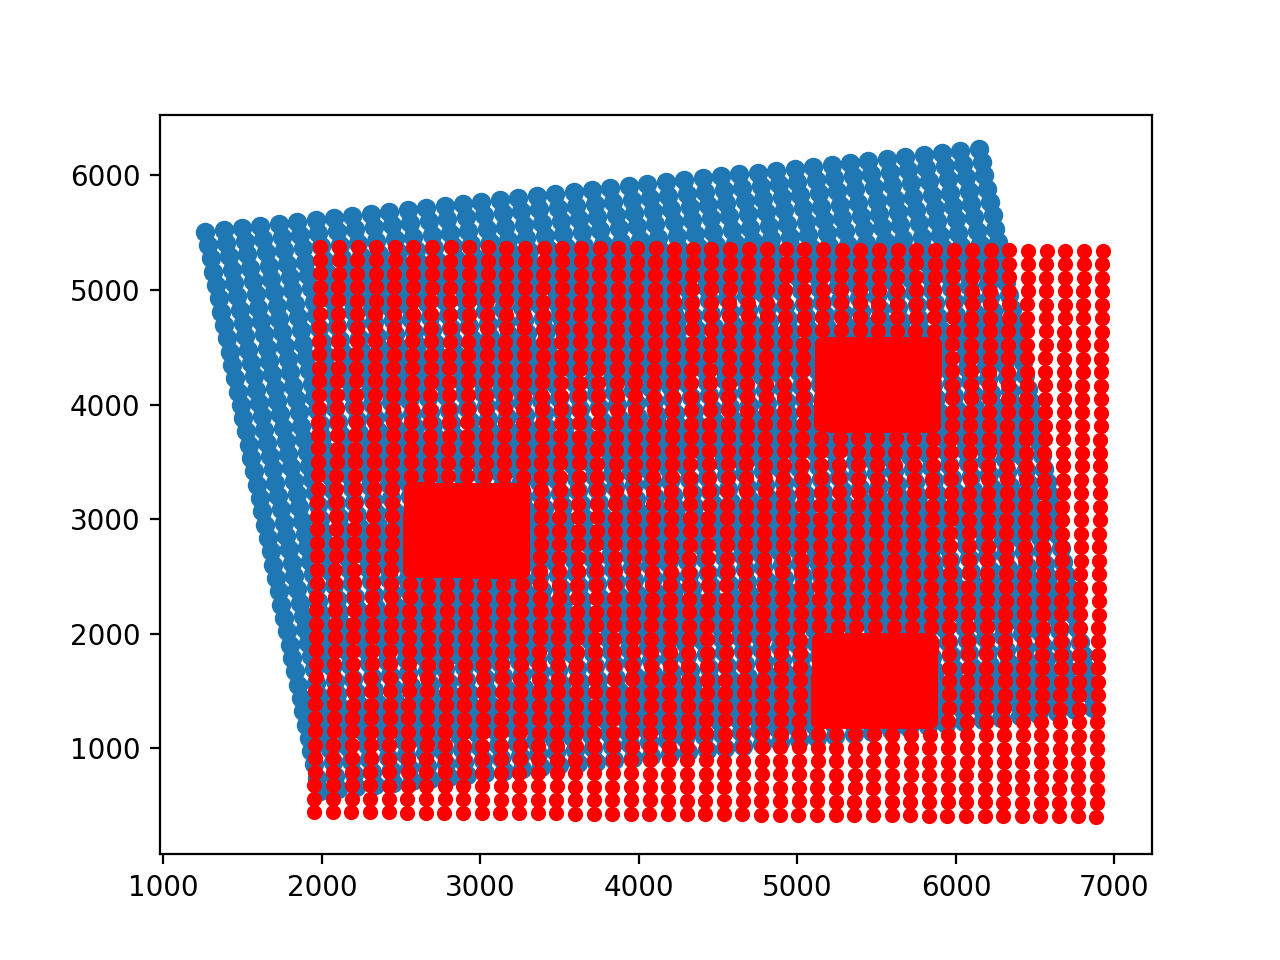

[ 4565.32569828  3378.47560482]
12.8524888622 517.058382867


In [102]:

#some testing stuff

xc=x1.mean()+20
yc=y1.mean()-30
xd=-500
yd=450
theta=30
scale=1

xa,xb=viscoords.transformGeneral(x1,y1,xd,yd,theta,scale,xc,yc)

visplot.checkMatched(x1,y1,xa,xb,prefix,inter)

transformation,xd,yd,sx,sy,rotation=viscoords.getTransform(x1,y1,xa,xb,1)
xc1,yc1=viscalc.getCentre(transformation)
print(xc1-xc,yc1-yc)

xa,xb=viscoords.transformGeneral(x1,y1,-50,45,0.3,1,0,0)

#visplot.checkMatched(x1,y1,xa,xb,prefix,inter)
transformation,xd,yd,sx,sy,rotation=viscoords.getTransform(x1,y1,xa,xb,1)
#print(xd,yd,sx,sy,rotation)
